This notebook reproduces what the MCP detector correction code is supposed to perform. The final script will only required 2 parameters, the **input folder** and the **output folder**

In [43]:
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import pprint
import os
import shutil

import matplotlib.pyplot as plt
%matplotlib notebook

from NeuNorm.normalization import Normalization
# this library can be installed using > pip install NeuNorm

# Instructions 

Here we define the 2 input parameters to the program
 * input_folder
 * output_folder

In [4]:
input_folder = "data/raw_data/"
assert Path(input_folder).exists()

In [5]:
output_folder = 'data/corrected_data_calculated'
assert Path(output_folder).exists()

## This is only for testing purpose 

The *expected_folder* is defined here only for testing purpose in this notebook and should not be part of the script.

In [23]:
expected_folder = 'data/corrected_data_expected/'
assert Path(expected_folder).exists()

# Setup 

The **setup** step will read the 3 ascii files which are part of the input folder. If any of those are missing an error should be raised.

In [8]:
shutter_dict = {}

### ShutterCount.txt 

First, the program will locate, in that folder, the file names that ends by *_ShutterCount.txt* and read it in order to isolate the number of count for each shutter.

__Handling errors__: If file can not be located, error should be raised ("Missing ShutterCount.txt in folder")

In [9]:
shutter_count_file = glob.glob(input_folder + '/*_ShutterCount.txt')[0]
assert Path(shutter_count_file).exists()

In [10]:
shutter_count_pd = pd.read_csv(shutter_count_file, sep='\t', names=['shutter_index', 
                                                                    'shutter_counts'])

# isolate only the shutter counts
shutter_counts = shutter_count_pd['shutter_counts']
for shutter_index, shutter_counts in enumerate(shutter_counts):
    if shutter_counts == 0:
        break
    shutter_dict[shutter_index] = {'counts': shutter_counts}
    
# pprint.pprint(shutter_dict)

### ShutterTimes.txt

This file needs to be retrieved and read as well in order to figure out when the various frames start and end (in microS)

In [11]:
shutter_time_file = glob.glob(input_folder + '/*_ShutterTimes.txt')[0]
assert Path(shutter_time_file).exists()

In [12]:
shutter_time_pd = pd.read_csv(shutter_time_file, sep='\t', names=['shutter_index',
                                                                 'start_frame',
                                                                 'end_frame'])
# isolate only the start and end
shutter_start_time = shutter_time_pd['start_frame']
shutter_end_time = shutter_time_pd['end_frame']

global_offset = 0
for shutter_index, start_time in enumerate(shutter_start_time):
    if shutter_end_time[shutter_index] == 0:
        break
    shutter_dict[shutter_index]['start_time'] = start_time + global_offset
    global_offset += start_time
    shutter_dict[shutter_index]['end_time'] = shutter_end_time[shutter_index] + global_offset
    global_offset += shutter_end_time[shutter_index]

### Spectra.txt

In [13]:
spectra_file = glob.glob(input_folder + '/*_Spectra.txt')[0]
assert Path(spectra_file).exists()

In [15]:
spectra_file_pd = pd.read_csv(spectra_file, sep='\t', names=['shutter_time',
                                                             'counts'])

#we are really only interested by the first column
spectra_time_array = np.array(spectra_file_pd['shutter_time'])

# pprint.pprint(spectra_file_pd)

In [17]:
# plt.figure()
# plt.plot(spectra_time_array)
# plt.title("Spectra time")

### When does each frame starts and ends?

We will use the data retrieve in the specta.txt and ShutterTimes.txt to figure out which file belongs to which frame

In [18]:
def find_nearest_index(array, value):
    perfect_match = (0 in (np.abs(np.array(array) - value)))
    idx = (np.abs(np.array(array) - value)).argmin()
    return perfect_match, idx

In [20]:
for _frame_index in shutter_dict.keys():
    start_time = shutter_dict[_frame_index]['start_time']
    perfect_match, nearest_start_index = find_nearest_index(spectra_time_array, start_time)
    shutter_dict[_frame_index]['start_index'] = nearest_start_index

    end_time = shutter_dict[_frame_index]['end_time']
    perfect_match, nearest_end_index = find_nearest_index(spectra_time_array, end_time)
    shutter_dict[_frame_index]['end_index'] = nearest_end_index
    
# make list of runs for each frame
for _frame_index in shutter_dict.keys():
    start_index = shutter_dict[_frame_index]['start_index']
    end_index = shutter_dict[_frame_index]['end_index']
    shutter_dict[_frame_index]['list_runs'] = np.arange(start_index, end_index+1)

# Load the data 

In [21]:
list_input_files = glob.glob(input_folder + '/*.fits')
list_input_files.sort()

# removing _SummedImg.fits as this file is not used but always in the folder
clean_list_input_files = []
for _file in list_input_files:
    if "_SummedImg.fits" in _file:
        continue
    clean_list_input_files.append(_file)

list_input_files = clean_list_input_files
    
o_norm = Normalization()
o_norm.load(file=list_input_files, notebook=True)

#### load expected data 

In [24]:
list_expected_input_files = glob.glob(expected_folder + '/*.fits')
list_expected_input_files.sort()
clean_list_expected_input_files = []
for _file in list_expected_input_files:
    if "_SummedImg.fits" in _file:
        continue
    clean_list_expected_input_files.append(_file)

list_expected_input_files = clean_list_expected_input_files

o_expected = Normalization()
o_expected.load(file=list_expected_input_files, notebook=True)

expected_data = o_expected.data['sample']['data']
expected_profile = [np.mean(_data) for _data in expected_data[:][:]]

# Code 

In [25]:
raw_data = o_norm.data['sample']['data']
pixel_occupancy_probablity = np.zeros(np.shape(raw_data))

Calculating the pixel occupancy probability

In [26]:
shutter_n_ratio_array = np.ones((len(list_input_files)))
for shutter_index in shutter_dict.keys():
    list_runs = shutter_dict[shutter_index]['list_runs']
    shutter_counts = shutter_dict[shutter_index]['counts']
    starting_run = list_runs[0]
    shutter_n_ratio = shutter_counts / shutter_dict[0]['counts']
    for _run in list_runs[1:]:
        pixel_occupancy_probablity[:][:][_run] = np.sum(raw_data[:][:][starting_run: _run], 0) / np.float(shutter_counts)
        shutter_n_ratio_array[_run] = shutter_n_ratio

In [27]:
data_corrected = raw_data / (1 - pixel_occupancy_probablity)

In [28]:
new_data_corrected = np.zeros((np.shape(data_corrected)))
for _index, _data in enumerate(data_corrected):
    new_data = _data / shutter_n_ratio_array[_index]
    new_data_corrected[_index] = new_data
    
data_corrected = new_data_corrected

# Testing 

This is just for testing purpose and should not be part of the script

In [30]:
raw_profile = [np.mean(_data) for _data in raw_data[:][:]]
corrected_profile = [np.mean(_data) for _data in data_corrected[:][:]]


<IPython.core.display.Javascript object>


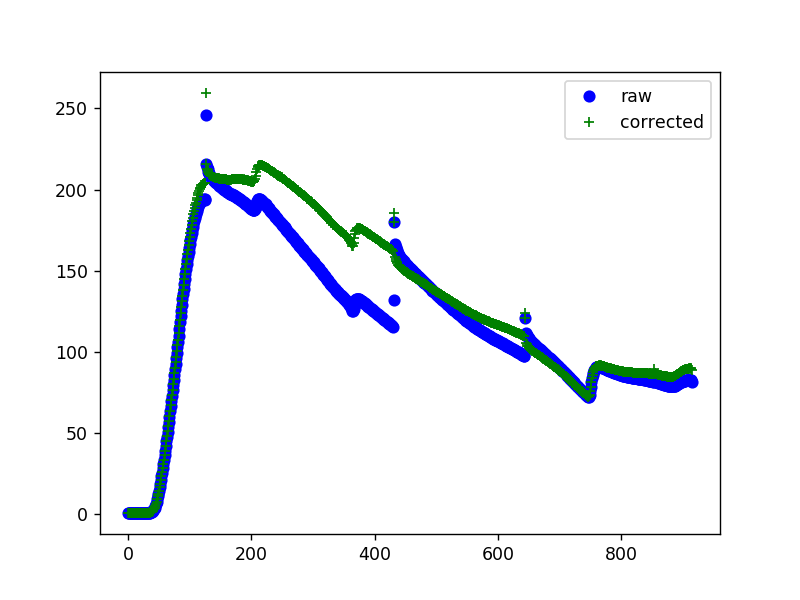

In [31]:
plt.figure()
plt.plot(raw_profile,'bo', label='raw')
# plt.plot(corrected_profile_without_removing_anything, 'r.', label='no data removed')
plt.plot(corrected_profile, 'g+', label='corrected')
plt.legend()

## Compare profile with expected profile

<IPython.core.display.Javascript object>


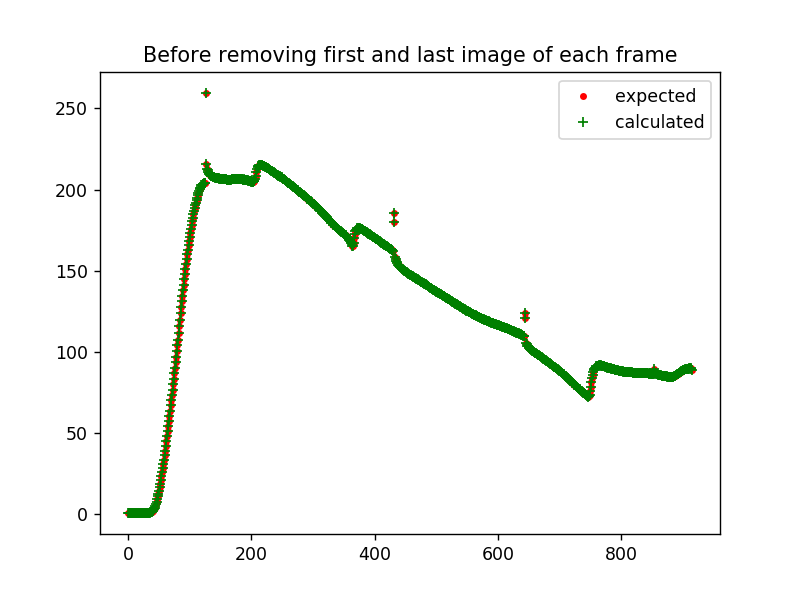

In [32]:
plt.figure()
plt.plot(expected_profile, 'r.', label='expected')
plt.plot(corrected_profile, 'g+', label='calculated')
plt.title("Before removing first and last image of each frame")
plt.legend()

<IPython.core.display.Javascript object>


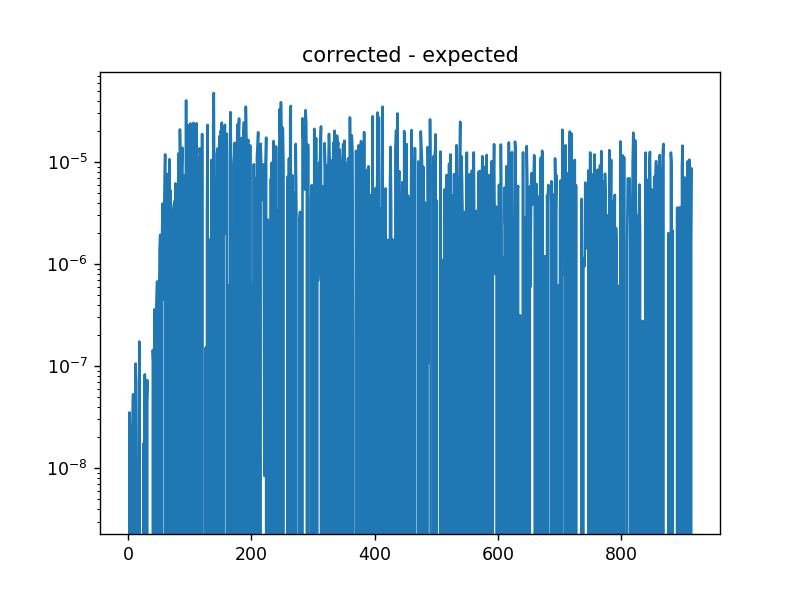

Text(0.5, 1.0, 'corrected - expected')

In [64]:
diff = np.array(corrected_profile) - np.array(expected_profile)

plt.figure()
plt.semilogy(diff)
plt.title("corrected - expected")

# Remove first and last image of each frame 

This is a very important part of the script as it cleans up the data

In [33]:
# because we are going to remove files and infos via index, we need to start from the end
list_shutter = list(shutter_dict.keys())
list_shutter.sort()
reverse_list_shutter = list_shutter[::-1]
for frame_index in reverse_list_shutter:
    end_index = shutter_dict[frame_index]['end_index']
    list_input_files = np.delete(list_input_files, end_index)
    data_corrected = np.delete(data_corrected, end_index, 0)
    spectra_file_pd.drop(end_index, inplace=True)
    
    start_index = shutter_dict[frame_index]['start_index']
    list_input_files = np.delete(list_input_files, start_index)
    data_corrected = np.delete(data_corrected, start_index, 0)
    spectra_file_pd.drop(start_index, inplace=True)
    
spectra_time_array_after_cleaning = np.array(spectra_file_pd['shutter_time'])

# export images, copy _ShutterCount.txt, _ShutterTimes.txt and  replace _Spectra.txt 

## images

In [145]:
short_list_input_files = [os.path.basename(_file) for _file in list_input_files]
o_norm.data['sample']['data'] = data_corrected
o_norm.export(folder=output_folder, data_type='sample')

## _Spectra.txt 

In [42]:
output_spectra_file = os.path.join(output_folder, os.path.basename(spectra_file))
spectra_file_pd.to_csv(output_spectra_file, 
                       columns=['shutter_time', 'counts'],
                      index_label=False,
                      index=False)

In [45]:
new_shutter_time_file = os.path.join(output_folder, os.path.basename(shutter_time_file))
shutil.copyfile(shutter_time_file, new_shutter_time_file)

'data/corrected_data_calculated/OB_1_005_ShutterTimes.txt'

In [46]:
new_shutter_count_file = os.path.join(output_folder, os.path.basename(shutter_count_file))
shutil.copyfile(shutter_count_file, new_shutter_count_file)

'data/corrected_data_calculated/OB_1_005_ShutterCount.txt'